
<h2 align="center">Experiments (Sander's paper, fig.2, dynamics)</h2> 

In [20]:
# Imports
import math as m
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
import pylab as pl
from pylab import exp,cos,sin,pi,tan, pi
import pandas as pd
import seaborn as sb
import holoviews as hv
from IPython.display import SVG
import io
from PIL import Image
from random import random
import elastica as el
import elastica_neurons as en
from dynamics import *
from experiments import *
import matplotlib.pyplot as mpl
%matplotlib inline
hv.notebook_extension()

Central orientation is $\cfrac{\pi}{2}$ (vertical bar) and the flanker orienatation is $\cfrac{\pi}{2} + \cfrac{\pi}{10}$. In this notebook we built a dynamic model using the elastica energy and compare the response to the already implemented passive model (see other notebook). Another important distinction between the two implementations, apart from the added dynamics is how we model the modulation. In both of the models we use an additive model. In both the passive and dynamic model, we use certain numbers of orientation selective neurons to decode the response of the center bar. However in the passive model (elastica model), we don't model the the flanker's bar response with orientation selective neurons. Rather we just calculate the energy between the orientation selective neurons of the center bar and the flanker's orientation.

In this model we change two things. First of all we model the flanker with orientation selective neurons. We also add recurrence, by not only applying modulation from the flanker to the center bar, but also back from the center to the flanker bar. The responses change with time, until they settle to a stable point.

The result from the passive and dynamic model can be seen below.

In [39]:
#----- Define some variables -----

# number of neurons
nosn = 32
nn = nosn
number_of_experiments = 25
center = np.pi/2
# constants for von mises function
A = 0.25
k = 5
# offset energy
E0 = 4

# elastica energies for different flanker orientations (calculated below)
energies = np.zeros(nn)



# used for simulation
timesteps = 50
tau = 6

locations = np.array([[0,0],[1,0],[-1,0],[0.5,np.sqrt(3)/2],[-0.5,np.sqrt(3)/2],[0.5,-np.sqrt(3)/2],[-0.5,-np.sqrt(3)/2]])


a = 0.15
a = 0.2
R = np.array([6,12,18,24,30])
a_pas = a/R
a_dyn = a/R/(nosn)

# colormaps - np.linspace(0, 1, len(a)) can be used as well
colors_cen = mpl.cm.autumn((np.arange(0, 1, 1.0/len(a_dyn))+0.3)/1.2)
colors_fla = mpl.cm.Blues((np.arange(0, 1, 1.0/len(a_dyn))+0.3)/1.2)

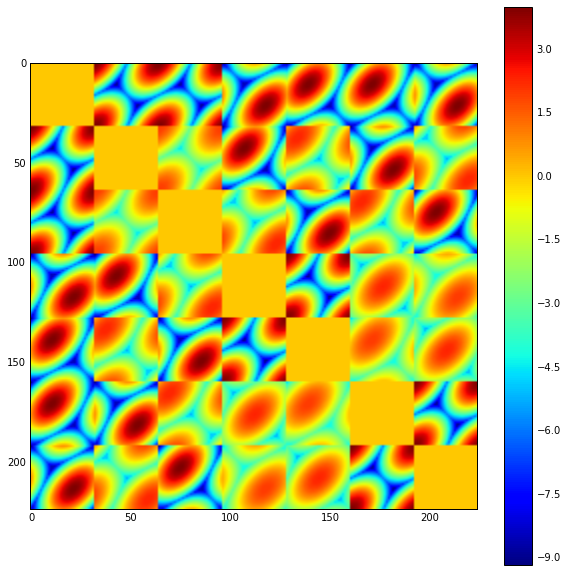

In [3]:
matrix2 = calculateMatrixF(locations,nosn=nosn)

In [4]:
'''
mpl.rcParams.update({'font.size':32})
fig_size = 20
plt.figure(figsize=[fig_size, fig_size])
plt.imshow(matrix)
plt.colorbar(shrink=0.8, pad = 0.05)
plt.xticks([50,150,250],['left flanker', 'center', 'right flanker'])
plt.yticks([50,150,250],['left flanker', 'center', 'right flanker'])
plt.savefig('../Report/Pictures/experiments/fig5/figB/matrix.png', dpi=200,bbox_inches='tight')
'''

"\nmpl.rcParams.update({'font.size':32})\nfig_size = 20\nplt.figure(figsize=[fig_size, fig_size])\nplt.imshow(matrix)\nplt.colorbar(shrink=0.8, pad = 0.05)\nplt.xticks([50,150,250],['left flanker', 'center', 'right flanker'])\nplt.yticks([50,150,250],['left flanker', 'center', 'right flanker'])\nplt.savefig('../Report/Pictures/experiments/fig5/figB/matrix.png', dpi=200,bbox_inches='tight')\n"

In [5]:
#----- One line of one of the squares of the matrix -----
#plt.plot(matrix[0,100:200])
#nosn

In [40]:
setNumberOfColors(number_of_experiments)

orientations = np.arange(0, np.pi, np.pi/nosn)

flanker_orientation = pl.linspace(pl.pi/2,pl.pi,number_of_experiments)
flankers1 = np.zeros((a_dyn.shape[0],number_of_experiments))
flankers2 = np.zeros((a_dyn.shape[0],number_of_experiments))
flankers3 = np.zeros((a_dyn.shape[0],number_of_experiments))
flankers4 = np.zeros((a_dyn.shape[0],number_of_experiments))
flankers5 = np.zeros((a_dyn.shape[0],number_of_experiments))
flankers6 = np.zeros((a_dyn.shape[0],number_of_experiments))
centers = np.zeros((a_dyn.shape[0],number_of_experiments))

print(A,k)
for i in range(number_of_experiments):
    for j in range(a_dyn.shape[0]):
        responses = np.zeros((nosn, timesteps))
        t = np.arange(0,timesteps,1)
        ac_orient = np.array([[center],[flanker_orientation[i]],[flanker_orientation[i]],[flanker_orientation[i]],[flanker_orientation[i]],[flanker_orientation[i]],[flanker_orientation[i]]])
        spikes_ = vonMises(A,k,ac_orient,orientations)
        spikes = spikes_.ravel(order='F')
        r = np.zeros(len(spikes))
        drdt = spikes/tau
        rs = np.zeros(spikes.shape + (len(t),))
        matrix = a_dyn[j]*matrix2
        for s in range(len(t)):
            r = r + drdt
            drdt = (-r + (spikes + np.dot(matrix,r)).clip(min=0))/tau
            rs[:,s] = r
        rs = np.reshape(rs, spikes_.shape + (len(t),), order='F')
        (direction, magnitude) = populationVector(orientations, rs, nosn, timesteps)
        flankers1[j,i] = direction[1,0,number_of_experiments-1]
        flankers2[j,i] = direction[2,0,number_of_experiments-1]
        flankers3[j,i] = direction[3,0,number_of_experiments-1]
        flankers4[j,i] = direction[4,0,number_of_experiments-1]
        flankers5[j,i] = direction[5,0,number_of_experiments-1]
        flankers6[j,i] = direction[6,0,number_of_experiments-1]
        centers[j,i] = direction[0,0,number_of_experiments-1]

(0.25, 5)


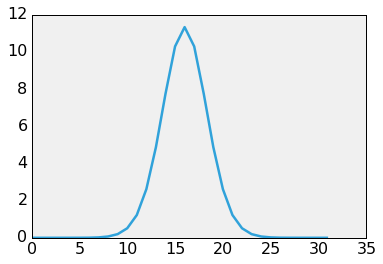

In [41]:
rs.shape
plt.plot(rs[:,0,0,1])

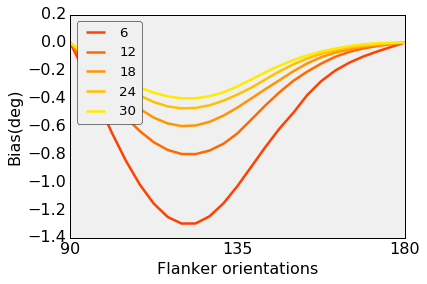

In [42]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
for i in np.arange(0,a_dyn.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot((centers[i,:]-np.pi/2)*57.2958, label=R[i], color=colors_cen[i])")
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=2)
plt.xlim([0,24])
#plt.ylim([-5.5,5.5])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90,  135,  180])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(deg)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/d_cen_f.png', dpi=200,bbox_inches='tight')

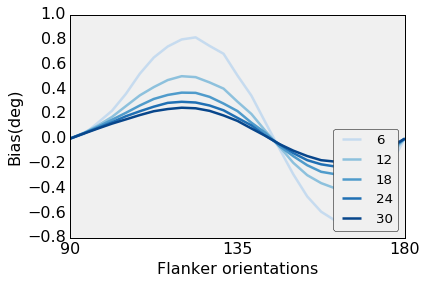

In [15]:
#### import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
for i in np.arange(0,a_dyn.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot(norm_plot(flankers1[i,:]-flanker_orientation)*57.2958, label=R[i], color=colors_fla[i])")
#for i in np.arange(0,a.shape[0],1):
#    plt.plot(flankers[i,:]-flanker_orientation)
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=4)
plt.xlim([0,24])
#plt.ylim([-90,90])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90,  135,  180])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(deg)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/d_flan_f1.png', dpi=200,bbox_inches='tight')

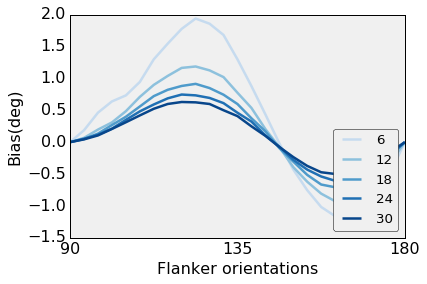

In [7]:
#### import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
for i in np.arange(0,a_dyn.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot(norm_plot(flankers2[i,:]-flanker_orientation)*57.2958, label=R[i], color=colors_fla[i])")
#for i in np.arange(0,a.shape[0],1):
#    plt.plot(flankers[i,:]-flanker_orientation)
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=4)
plt.xlim([0,24])
#plt.ylim([-90,90])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90,  135,  180])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(deg)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/d_flan_f2.png', dpi=200,bbox_inches='tight')

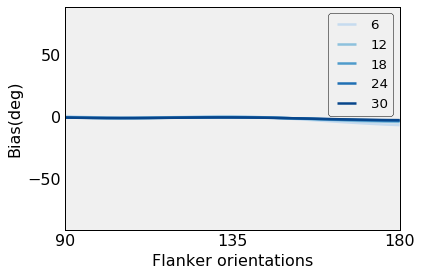

In [8]:
#### import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
for i in np.arange(0,a_dyn.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot(norm_plot(flankers3[i,:]-flanker_orientation)*57.2958, label=R[i], color=colors_fla[i])")
#for i in np.arange(0,a.shape[0],1):
#    plt.plot(flankers[i,:]-flanker_orientation)
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=1)
plt.xlim([0,24])
plt.ylim([-90,90])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90,  135,  180])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(deg)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/d_flan_f3.png', dpi=200,bbox_inches='tight')

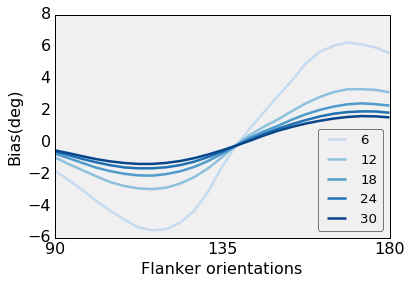

In [9]:
#### import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
for i in np.arange(0,a_dyn.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot(norm_plot(flankers4[i,:]-flanker_orientation)*57.2958, label=R[i], color=colors_fla[i])")
#for i in np.arange(0,a.shape[0],1):
#    plt.plot(flankers[i,:]-flanker_orientation)
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=4)
plt.xlim([0,24])
#plt.ylim([-90,90])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90,  135,  180])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(deg)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/d_flan_f4.png', dpi=200,bbox_inches='tight')

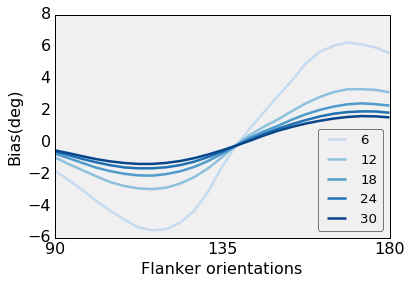

In [10]:
#### import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
for i in np.arange(0,a_dyn.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot(norm_plot(flankers5[i,:]-flanker_orientation)*57.2958, label=R[i], color=colors_fla[i])")
#for i in np.arange(0,a.shape[0],1):
#    plt.plot(flankers[i,:]-flanker_orientation)
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=4)
plt.xlim([0,24])
#plt.ylim([-90,90])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90,  135,  180])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(deg)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/d_flan_f5.png', dpi=200,bbox_inches='tight')

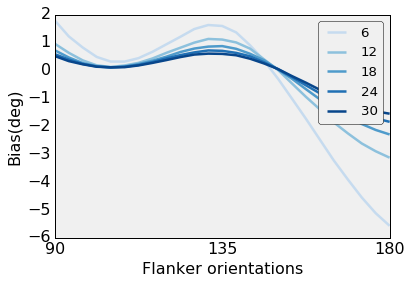

In [11]:
#### import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
for i in np.arange(0,a_dyn.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot(norm_plot(flankers6[i,:]-flanker_orientation)*57.2958, label=R[i], color=colors_fla[i])")
#for i in np.arange(0,a.shape[0],1):
#    plt.plot(flankers[i,:]-flanker_orientation)
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=1)
plt.xlim([0,24])
#lt.ylim([-5,5])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90,  135,  180])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(deg)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/d_flan_f6.png', dpi=200,bbox_inches='tight')

In [28]:
%output size=300
#flankers_[0,] = flankers[0,:]-flanker_orientation
plot = hv.Curve(norm_plot(flankers[0,:]-flanker_orientation))
for i in np.arange(1,a_dyn.shape[0],1):
    plot *= hv.Curve(norm_plot(flankers[i,:]-flanker_orientation))
#plot(plot={'aspect':3})

NameError: name 'flankers' is not defined

In [37]:
flanker_orientation = pl.linspace(pl.pi/2,pl.pi,number_of_experiments)
flankers = np.zeros((a_pas.shape[0],number_of_experiments))
centers = np.zeros((a_pas.shape[0],number_of_experiments))
orientations = np.arange(0, np.pi, np.pi/nosn)
k = 1.5
A = 1
for i in range(number_of_experiments):
    for j in range(a_pas.shape[0]):
        # elastica energies for different flanker orientations (calculated below)
        energies = np.zeros(nn)


        # Elastica energies between neuron with orientation 1 rad and population of 32 neurons with variable orientation from 0 to pi
        for s in range(nn):
            energies[s] = 2*en.E(orientations[s],flanker_orientation[i],[locations[1][0],locations[1][1]])
            energies[s] += 2*en.E(orientations[s],flanker_orientation[i],[locations[3][0],locations[3][1]])
            energies[s] += 2*en.E(orientations[s],flanker_orientation[i],[locations[5][0],locations[5][1]])



        modulation_ad = -a_pas[j]*(energies - 6*E0)


        # Central drive
        curve,x,y = mises_curve(A,k,center,neuron=nn)
        centers[j,i] = popvec((y+modulation_ad).clip(min=0),nn)


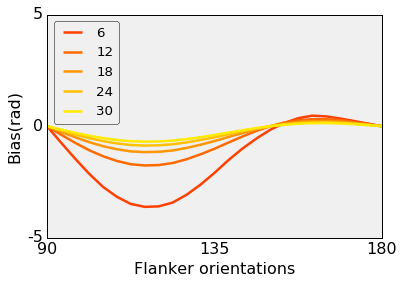

In [38]:
for i in np.arange(0,a_pas.shape[0],1):
    name = 'cen' + str(i) + ','
    exec(name + " = plt.plot(norm_plot(centers[i,:]-np.pi/2)*57.2958, label=R[i], color=colors_cen[i])")
plt.legend(handles=[cen0,cen1,cen2,cen3,cen4], loc=2)
plt.xlim([0,24])
#plt.ylim([-5.5,5.5])
plt.yticks([-5,0,5],[-5,0,5])
plt.xticks([0,12,24],[90, 135, 180])
#plt.yticks([-5,0,5],[-5,0,5])
plt.xlabel('Flanker orientations')
plt.ylabel('Bias(rad)')
plt.savefig('../Report/Pictures/experiments/fig5/figF/p_cen_f.png', dpi=200,bbox_inches='tight')

In [85]:
%output size=300
plot = hv.Curve(norm_plot(centers[0,:]-np.pi/2))
for i in np.arange(1,a_pas.shape[0],1):
    plot *= hv.Curve(norm_plot(centers[i,:]-np.pi/2))
#plot(plot={'aspect':3})